# **Clasificación de imágenes con Redes Neuronales Convolucionales (CNN)**
---

## Objetivos

---

## Descripción del proyecto

---

## **Carga de los datos**

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import keras.datasets.cifar10 as cifar10

from tensorflow import keras
from keras.utils import to_categorical

In [2]:
# Se definen los datos de entrenamiento, validación y test
(X, Y), (x_test, y_test) = cifar10.load_data()
(x_train, x_valid) = (X[:40000], X[40000:])
(y_train, y_valid) = (Y[:40000], Y[40000:])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 62s 0us/step


In [3]:
# Normalizo los datos de entrada para que estén entre 0 y 1
x_train = x_train / 255.
x_valid = x_valid / 255.
x_test = x_test / 255.

In [4]:
# Mapeo de número de clase a elemento (animal o vehículo) correspondiente en CIFAR-10
MAP_ELEMENTS = {
    0: 'avion', 1: 'coche', 2: 'ave',
    3: 'gato', 4: 'ciervo', 5: 'perro', 6: 'rana',
    7: 'caballo', 8: 'barco', 9: 'camion'
}

In [5]:
# Función para convertir las etiquetas a codificación one-hot (vector de 10 elementos)
def convert_to_one_hot(labels, num_classes):
    return np.squeeze(np.array([to_categorical(label, num_classes=num_classes) for label in labels]))

# Convierto las etiquetas de entrenamiento, validación y test a codificación one-hot
num_classes = 10
y_train_one_hot = convert_to_one_hot(y_train, num_classes)
y_valid_one_hot = convert_to_one_hot(y_valid, num_classes)
y_test_one_hot = convert_to_one_hot(y_test, num_classes)

# Verifico las conversiones
print(y_train_one_hot.shape)
print(y_valid_one_hot.shape)
print(y_test_one_hot.shape)

(40000, 10)
(10000, 10)
(10000, 10)


## **Visualización del dataset CIFAR-10**

Mostraré algunas imágenes del dataset con sus etiquetas para entender mejor los datos.

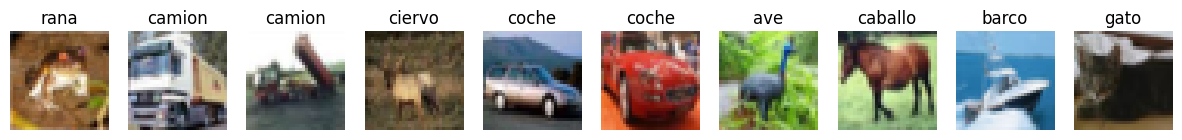

In [6]:
# Función para mostrar imágenes con etiquetas
def plot_images(images, labels, class_names, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(class_names[labels[i][0]])
        ax.axis("off")
    plt.show()

# Mostrar 10 imágenes aleatorias del conjunto de entrenamiento
plot_images(X[:10], Y[:10], MAP_ELEMENTS)

Podemos ver 10 ejemplos extraídos del conjunto de entrenamiento del dataset con su etiqueta asociada. Como se indica en la descripción, este conjunto está compuesto por clases que incluyen tanto animales como vehículos. De esta forma podemos observar la diversidad y complejidad de las imágenes, ya que cada clase tiene variaciones en cuanto a poses, ángulos, iluminación y fondo.

## **CNN básica**

Empezaré por un modelo básico de CNN para realizar un primer análisis y establecer una línea base de rendimiento. Este diseño lo ajustará en iteraciones posteriores.

Se usarán siguientes técnicas para la arquitectura del modelo:
- Dropout
- Adam
- Learning rate de 0.001
- 50 epochs

### **Definición del modelo**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def cnn_inicial(input_shape=(32, 32, 3), num_classes=10): # Espero recibir imágenes 32x32 con 3 canales RGB y 10 clases
    model = Sequential([

        # Primera capa de 32 neuronas
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape), # Padding='same' para mantener el tamaño de la imagen de entrada
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Segunda capa de 64 neuronas
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Tercera capa de 128 neuronas
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(), # Aplana la salida de la última capa para poder conectarla a una capa full connected

        Dense(128, activation='relu'),           # Capa full connected con 128 neuronas
        Dropout(0.5),                            # Apaga aleatoriamente el 50% de las neuronas durante el entrenamiento para prevenir overfitting y mejorar la generalización.

        Dense(num_classes, activation='softmax') # Capa de salida con 10 neuronas y función de activación softmax 
    ])
    return model

model = cnn_inicial() # Creo el modelo
model.summary()       # Muestro el resumen del modelo


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

### **Compilación y entrenamiento**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compilo el modelo (Optimizador Adam)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Defino callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)           # Para detener el entrenamiento si hay 10 epochs sin mejoras
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)    # Guardo el mejor modelo durante el entrenamiento

# Entreno el modelo
history = model.fit(x_train, y_train_one_hot,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_valid, y_valid_one_hot),
                    callbacks=[early_stop, checkpoint])            

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.2375 - loss: 2.0350 - val_accuracy: 0.4580 - val_loss: 1.5147
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.4464 - loss: 1.5049 - val_accuracy: 0.5589 - val_loss: 1.2601
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5086 - loss: 1.3683 - val_accuracy: 0.5908 - val_loss: 1.1533
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5518 - loss: 1.2609 - val_accuracy: 0.6262 - val_loss: 1.0637
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5830 - loss: 1.1906 - val_accuracy: 0.6239 - val_loss: 1.0459
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5990 - loss: 1.1283 - val_accuracy: 0.6515 - val_loss: 0.9753
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6159 - loss: 1.0835 - val_accuracy: 0.6795 - val_loss: 0.9074
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.6319 - loss: 1.0408 - 

### **Gráficas de precisión y pérdida durante el entrenamiento**

In [ ]:
#Gráfica de precisión y pérdida durante el entrenamiento
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))

    #Precisión
    axs[0].plot(history.history['accuracy'], label='Precisión entrenamiento')
    axs[0].plot(history.history['val_accuracy'], label='Precisión validación')
    axs[0].set_title('Precisión durante el entrenamiento')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()

    #Pérdida
    axs[1].plot(history.history['loss'], label='Pérdida entrenamiento')
    axs[1].plot(history.history['val_loss'], label='Pérdida validación')
    axs[1].set_title('Pérdida durante el entrenamiento')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Pérdida')
    axs[1].legend()

    plt.show()

plot_training_history(history)


Se observa una convergencia estable, con una pérdida que disminuye de manera constante y una precisión que aumenta progresivamente.

La pérdida del conjunto de validación se estabiliza alrededor del final del entrenamiento, lo que indica que el modelo podría beneficiarse de ajustes en la regularización.

### **Análisis de resultados**

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

best_model = keras.models.load_model('best_model.keras') # Cargo el mejor modelo

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)


conf_mat = confusion_matrix(y_true, y_pred_classes) # Matriz de confusión


plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=MAP_ELEMENTS.values(),
            yticklabels=MAP_ELEMENTS.values())
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()


# Reporte de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=MAP_ELEMENTS.values())
print(class_report)


NameError: name 'keras' is not defined

Las categorías de vehículos obtuvieron las mejores puntuaciones en general, probablemente debido a que los vehículos suelen tener formas más definidas y colores más consistentes en comparación con los animales, dónde un camión tiene una forma rectangular clara, mientras que un gato puede aparecer sentado, acostado, etc. Además, los vehículos suelen aparecer en entornos más uniformes como carreteras o parkings, en cambio los animales pueden aparecer en zonas silvestres o interiores de casas, que son más variados.

Podemos ver como en las categorías donde se están cometiendo más errores son "perro" y "gato", debido a la similitud entre características similares (4 patas, forma de la cara, pelaje, etc).

### **Análisis de errores**

In [ ]:
incorrect_indices = np.where(y_pred_classes != y_true)[0] # Encuentra índices de predicciones incorrectas

# Muestro algunas imágenes incorrectas
def plot_incorrect_predictions(indices, num=9):
    plt.figure(figsize=(10,10))
    for i, idx in enumerate(indices[:num]):
        plt.subplot(3,3,i+1)
        plt.imshow(x_test[idx])
        plt.title(f"Verdadera: {MAP_ELEMENTS[y_true[idx]]}\nPredicha: {MAP_ELEMENTS[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.show()

plot_incorrect_predictions(incorrect_indices)

### **Conclusiones**

El primer modelo entrenado utilizando una CNN básica obtuvo un rendimiento global del 77% de precisión en el conjunto de test, lo cual representa una buena base para futuros ajustes. Estos son los principales resultados obtenidos:

- La curva de pérdida y precisión muestra un progreso consistente
- El modelo podría beneficiarse de ajustes en la regularización dado que la pérdida del conjunto de validación se estabiliza hacia el final del entrenamiento.
- Los vehículos lograrón los mejores resultados en general.
- El análisis visual muestra que las confusiones suelen ocurrir entre clases con características visuales similares como "perro" y "gato", lo que indica que el modelo necesita captar mejor los detalles finos.

Ajustes que podrían mejorar los resultados del modelo:

- Regularización: Introducir técnicas como Dropout o Batch Normalization para reducir el sobreajuste y estabilizar el aprendizaje.
- Optimización de hiperparámetros: Ajustar la tasa de aprendizaje, número de filtros y tamaños de kernel para encontrar una configuración más óptima para el dataset.
- Incrementar el número de épocas para observar si el modelo sigue mejorando o comienza a estancarse.

## **CNN avanzada con BatchNormalization y L2**

Cambios realizados en el modelo, respecto al anterior:

- Se añade una capa convolucional extra.
- Se agrega Batch Normalization.
- Se agrega Regularización L2 en la capa final.
- Se reduce el Dropout.
- Se reduce el Learning rate a 0.0004.
- Aumento a 85 epochs con EarlyStopping menos restrictivo.

**Batch Normalization**: Consiste en normalizar las activaciones de cada capa convolucional o densa usando la media y varianza calculadas a partir de un mini-batch. Esto ayuda a estabilizar y acelerar el entrenamiento, ya que mantiene las distribuciones de las activaciones bajo control. Además, al permitir tasas de aprendizaje más altas y reducir la sensibilidad a la inicialización de pesos, suele llevar a modelos que convergen más rápido y con mejores resultados.

**Regularización L2**: Agrega al loss una penalización proporcional a la suma de los cuadrados de los pesos del modelo. La idea es forzar a que los pesos no crezcan demasiado, ayudando a reducir el overfitting. Cuanto mayor sea el coeficiente de penalización, mayor será la presión para mantener los pesos pequeños.

### **Definición del modelo**

In [ ]:
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l2

def cnn_avanzada(input_shape=(32, 32, 3), num_classes=10, weight_decay=1e-5):
    model = Sequential([
        
        # Primera capa convolucional con menos filtros para capturar características iniciales
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),           # Se aplica BatchNorm después de la convolución.
        Activation('relu'),             # Es preferible poner la capa de activación en una separada
        MaxPooling2D((2, 2)),
        Dropout(0.25),                  # Reduzco Dropout a 0.25

        # Segunda capa convolucional
        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)), # Se agrega l2
        BatchNormalization(),
        Activation('relu'),                   
        MaxPooling2D((2, 2)),
        Dropout(0.25),                         

        # Tercera capa convolucional
        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Cuarta capa convolucional
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),  # Aplana la salida de la última capa para poder conectarla a una capa full connected

        # Capa completamente conectada con regularización L2 y Batch Normalization
        Dense(128, kernel_regularizer=l2(1e-3)),   # Aplico un l2 de 1e-3 para esta capa
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),         # Reduzco Dropout a 0.4

        # Capa de salida
        Dense(num_classes, activation='softmax')
    ])
    return model

model_avanz = cnn_avanzada()  # Creo el modelo regularizado
model_avanz.summary()         # Resumen del modelo


### **Compilación y entrenamiento**

In [ ]:
model_avanz.compile(optimizer=Adam(learning_rate=0.0004), loss='categorical_crossentropy', metrics=['accuracy']) # Compilo con un learning rate reducido.

# Defino callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)         # Para detener el entrenamiento si hay 20 epochs sin mejoras
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)  # Guardo el mejor modelo durante el entrenamiento

# Entrenamiento del modelo
history_avanz = model_avanz.fit(x_train, y_train_one_hot,
                            epochs=85,                                   # Aumento del número de épocas
                            batch_size=128,                              # Aumento el tamaño del batch
                            validation_data=(x_valid, y_valid_one_hot),
                            callbacks=[early_stop, checkpoint])


### **Gráficas de precisión y pérdida durante el entrenamiento**

In [ ]:
# Gráfica de precisión y pérdida durante el entrenamiento
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Precisión
    axs[0].plot(history.history['accuracy'], label='Precisión entrenamiento')
    axs[0].plot(history.history['val_accuracy'], label='Precisión validación')
    axs[0].set_title('Precisión durante el entrenamiento')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()

    # Pérdida
    axs[1].plot(history.history['loss'], label='Pérdida entrenamiento')
    axs[1].plot(history.history['val_loss'], label='Pérdida validación')
    axs[1].set_title('Pérdida durante el entrenamiento')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Pérdida')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Llamada a la función
plot_training_history(history_avanz)


### **Análisis de resultados**

In [ ]:
# Cargo el mejor modelo
best_model = keras.models.load_model('best_model.keras')

# Predicciones y etiquetas verdaderas
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=MAP_ELEMENTS.values(),
            yticklabels=MAP_ELEMENTS.values())
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=MAP_ELEMENTS.values())
print(class_report)

El modelo ha mejorado significativamente el desempeño general de todas las clases, pero sigue teniendo dificultades con algunas como "gato", "ave" y "perro", que presentan una precisión y recall relativamente más bajos en comparación con las demás clases.

### **Análisis de errores**

In [ ]:
incorrect_indices = np.where(y_pred_classes != y_true)[0] # Encuentra índices de predicciones incorrectas

# Muestro algunas imágenes incorrectas
def plot_incorrect_predictions(indices, num=9):
    plt.figure(figsize=(10,10))
    for i, idx in enumerate(indices[:num]):
        plt.subplot(3,3,i+1)
        plt.imshow(x_test[idx])
        plt.title(f"Verdadera: {MAP_ELEMENTS[y_true[idx]]}\nPredicha: {MAP_ELEMENTS[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.show()

plot_incorrect_predictions(incorrect_indices)

### **Conclusiones**

El modelo avanzado supera por 6–7 puntos porcentuales al modelo de CNN básico anterior (de ~77% a ~83–84%). Esto indica que las modificaciones realizadas mejoraron la capacidad del modelo para generalizar y manejar datos complejos.

- Mientras que la CNN básica sólo utilizaba dropout, el modelo avanzado combina varias estrategias de regularización: dropout, BatchNormalization y regularización L2, lo que contribuye a reducir el sobreajuste sin dificultar excesivamente el aprendizaje.
- El uso de más filtros en las capas convolucionales permite capturar características más detalladas de las imágenes, resultando en un rendimiento no solo más alto, sino también más consistente.
- El cambio en la tasa de aprendizaje (de 0.001 a 0.0004) y un Dropout un poco más bajo en las capas convolucionales ha permitido un entrenamiento más fino en cada bloque convolucional.
- Un entrenamiento más prolongado con un mayor número de épocas (con mayor paciencia en EarlyStopping) deja que el modelo avanzado converja más, aprovechando la potencia de la red con más filtros.


Ajustes que podrían mejorar los resultados del modelo:

- Añadir Data Augmentation: Implementar técnicas de aumento de datos como rotaciones, recortes, zooms y ajustes de brillo puede mejorar la capacidad del modelo para generalizar, especialmente en clases con confusiones frecuentes.
- Incorporar Learning Rate Scheduler: Permitirá ajustar dinámicamente la tasa de aprendizaje cuando la red deje de mejorar.
- Ajustar aún más la regularización: Bajar un poco la L2 o quitarla de las capas convolucionales y subir ligeramente el dropout si la red se empieza a sobreajustar. O al revés, reducir un poco el dropout si todavía la red no llega a sobreajustar. El objetivo es encontrar el equilibrio perfecto.
- Incrementar el número de épocas para observar si el modelo sigue mejorando o comienza a estancarse.

## **CNN superior con Data Augmentation**

### **Definición del modelo**

### **Compilación y entrenamiento**

### **Gráficas de precisión y pérdida durante el entrenamiento**

### **Análisis de resultados**

### **Análisis de errores**

### **Conclusiones**

## **Conclusiones finales**

Recopilación de versiones:


| **Modelo**       | **Capas Conv** | **Dropout**    | **Batch Norm** | **Regularización L2** | **Data Augmentation** | **Precisión en Test** | **F1-Score Macro** | **Mejores Clases**      | **Peores Clases**      |
|-------------------|--------------------------|----------------|--------------------------|------------------------|------------------------|-----------------------|--------------------|------------------------|-----------------------|
| **CNN básica**         | 3                       | (0.3, 0.5)  | No                       | No                     | No                     | **77.0%**             | 0.77               | Camión, Coche, Barco    | Gato, Ave, Perro      |
| **CNN avanzada**         | 4                       | (0.25, 0.4)  | Sí                       | Sí                     | No                     | **83.0%**             | 0.83               | Coche, Barco, Camión   | Gato, Perro, Ave      |
| **CNN 3**         | 3                       | (0.2, 0.4)  | Sí                       | Sí                     | Sí                     | **76.0%**             | 0.76               | Camión, Barco, Caballo  | Gato, Ave, Perro      |



Añadir las epochs: 50 - 60 - 